In [1]:
import numpy as onp
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import *

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPU


In [3]:
DATASET = 'mnist'
class_num   = 10
test_size   = 2048
image_shape = None

if DATASET =='mnist':
    image_shape = (28, 28)
elif DATASET == 'cifar':
    image_shape = (32, 32, 3)

In [4]:
run = 10
batch_size = 512
epoch = 10

In [5]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [6]:
x_train_all, x_test_all = x_train_all/255, x_test_all/255

In [7]:
FGSM = []
PGD_10 = []
PGD_100 = []
for base_model_layer in range(0, 51, 10):
    FGSM.append(onp.load("%s_FGSM_%d_layer.npy"%(DATASET, base_model_layer)))
    PGD_10.append(onp.load("%s_PGD_10_%d_layer.npy"%(DATASET, base_model_layer)))
    PGD_100.append(onp.load("%s_PGD_10_%d_layer.npy"%(DATASET, base_model_layer)))

In [8]:
y_test = onp.load("%s_y_test.npy"%(DATASET))

In [9]:
x_test = onp.load("%s_x_test.npy"%(DATASET))

In [10]:
x_test.shape

(2048, 784)

In [11]:
class Model(tf.keras.Model):
    def __init__(self, layers):
        super(Model, self).__init__()
        self.layers_num = layers
        self.dense = [tf.keras.layers.Dense(512) for i in range(self.layers_num)]
        self.out = tf.keras.layers.Dense(10)
        
    def call(self, inputs):
        x = inputs
        for f in self.dense:
            x = f(x)
            x = tf.math.erf(x)
            
        out = self.out(x)
        return out

In [15]:
loss_curve = []
acc_curve  = []

loss_curve_FGSM = {idx*10+1: [] for idx in range(len(FGSM))}
acc_curve_FGSM  = {idx*10+1: [] for idx in range(len(FGSM))}

loss_curve_PGD_10 = {idx*10+1: [] for idx in range(len(FGSM))}
acc_curve_PGD_10  = {idx*10+1: [] for idx in range(len(FGSM))}

loss_curve_PGD_100 = {idx*10+1: [] for idx in range(len(FGSM))}
acc_curve_PGD_100  = {idx*10+1: [] for idx in range(len(FGSM))}

for i in range(run):
    model = Model(10)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    for j in range(int(epoch)):
        model.fit(x_train_all, y_train_all, batch_size=batch_size, epochs=10)
        # CLEAN
        r = model.evaluate(x_test, y_test, verbose=0)
        loss_curve.append(r[0])
        acc_curve.append(r[1])
        
        for idx, (F, _10, _100) in enumerate(zip(FGSM, PGD_10, PGD_100)):
                
            r = model.evaluate(F,    y_test, verbose=0)
            print("FGSM    %d,  loss: %.3f, acc: %.3f"%(idx*10+1, r[0], r[1]))
            loss_curve_FGSM[idx*10+1].append(r[0])
            acc_curve_FGSM[idx*10+1].append(r[1])
        
            r = model.evaluate(_10,  y_test, verbose=0)
            print("PGD-10  %d,  loss: %.3f, acc: %.3f"%(idx*10+1, r[0], r[1]))
            loss_curve_PGD_10[idx*10+1].append(r[0])
            acc_curve_PGD_10[idx*10+1].append(r[1])
            
            r = model.evaluate(_100, y_test, verbose=0)
            print("PGD-100 %d,  loss: %.3f, acc: %.3f"%(idx*10+1, r[0], r[1]))
            loss_curve_PGD_100[idx*10+1].append(r[0])
            acc_curve_PGD_100[idx*10+1].append(r[1])
            

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.7776 - accuracy: 0.7441
Epoch 2/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3334 - accuracy: 0.8975
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2828 - accuracy: 0.9131
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2582 - accuracy: 0.9212
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2384 - accuracy: 0.9263
Epoch 6/10
60000/60000 [==============================] - 1s 9us/sample - loss: 0.2239 - accuracy: 0.9308
Epoch 7/10
60000/60000 [==============================] - 0s 8us/sample - loss: 0.2114 - accuracy: 0.9340
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1807 - accuracy: 0.9439
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1898 - accuracy: 0.9401
Epoch 10/10
60000/600

PGD-10  11,  loss: 8.433, acc: 0.091
PGD-100 11,  loss: 8.433, acc: 0.091
FGSM    21,  loss: 8.831, acc: 0.104
PGD-10  21,  loss: 8.753, acc: 0.091
PGD-100 21,  loss: 8.753, acc: 0.091
FGSM    31,  loss: 8.844, acc: 0.107
PGD-10  31,  loss: 8.825, acc: 0.097
PGD-100 31,  loss: 8.825, acc: 0.097
FGSM    41,  loss: 8.848, acc: 0.108
PGD-10  41,  loss: 8.885, acc: 0.096
PGD-100 41,  loss: 8.885, acc: 0.096
FGSM    51,  loss: 8.933, acc: 0.111
PGD-10  51,  loss: 8.919, acc: 0.098
PGD-100 51,  loss: 8.919, acc: 0.098
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0622 - accuracy: 0.9791
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0660 - accuracy: 0.9779
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0850 - accuracy: 0.9716
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0702 - accuracy: 0.9755
Epoch 5/10
60000/60000 [===========

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0512 - accuracy: 0.9831
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0516 - accuracy: 0.9821
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0479 - accuracy: 0.9833
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0411 - accuracy: 0.9865
FGSM    1,  loss: 7.149, acc: 0.251
PGD-10  1,  loss: 6.455, acc: 0.276
PGD-100 1,  loss: 6.455, acc: 0.276
FGSM    11,  loss: 9.801, acc: 0.085
PGD-10  11,  loss: 9.830, acc: 0.071
PGD-100 11,  loss: 9.830, acc: 0.071
FGSM    21,  loss: 9.928, acc: 0.082
PGD-10  21,  loss: 10.198, acc: 0.065
PGD-100 21,  loss: 10.198, acc: 0.065
FGSM    31,  loss: 9.931, acc: 0.083
PGD-10  31,  loss: 10.272, acc: 0.068
PGD-100 31,  loss: 10.272, acc: 0.068
FGSM    41,  loss: 9.877, acc: 0.083
PGD-10  41,  loss: 10.230, acc: 0.068
PGD-100 41,  loss: 10.230, acc: 0.068
FGSM    51,  loss: 9.942, ac

60000/60000 [==============================] - 0s 8us/sample - loss: 0.1197 - accuracy: 0.9596
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1212 - accuracy: 0.9594
Epoch 3/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1244 - accuracy: 0.9595
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1224 - accuracy: 0.9596
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1085 - accuracy: 0.9632
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1170 - accuracy: 0.9607
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1014 - accuracy: 0.9658
Epoch 8/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1071 - accuracy: 0.9640
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1235 - accuracy: 0.9594
Epoch 10/10
60000/60000 [==============================

FGSM    21,  loss: 8.068, acc: 0.078
PGD-10  21,  loss: 8.517, acc: 0.062
PGD-100 21,  loss: 8.517, acc: 0.062
FGSM    31,  loss: 8.141, acc: 0.074
PGD-10  31,  loss: 8.514, acc: 0.064
PGD-100 31,  loss: 8.514, acc: 0.064
FGSM    41,  loss: 8.130, acc: 0.081
PGD-10  41,  loss: 8.484, acc: 0.064
PGD-100 41,  loss: 8.484, acc: 0.064
FGSM    51,  loss: 8.209, acc: 0.079
PGD-10  51,  loss: 8.531, acc: 0.065
PGD-100 51,  loss: 8.531, acc: 0.065
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0755 - accuracy: 0.9738
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0675 - accuracy: 0.9773
Epoch 3/10
60000/60000 [==============================] - 1s 10us/sample - loss: 0.0685 - accuracy: 0.9766
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0626 - accuracy: 0.9787
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0613 - accuracy: 0.9786
Ep

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0931 - accuracy: 0.9692
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0805 - accuracy: 0.9729
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0766 - accuracy: 0.9746
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0793 - accuracy: 0.9735
FGSM    1,  loss: 5.223, acc: 0.215
PGD-10  1,  loss: 4.729, acc: 0.262
PGD-100 1,  loss: 4.729, acc: 0.262
FGSM    11,  loss: 8.378, acc: 0.056
PGD-10  11,  loss: 8.387, acc: 0.052
PGD-100 11,  loss: 8.387, acc: 0.052
FGSM    21,  loss: 8.826, acc: 0.048
PGD-10  21,  loss: 9.031, acc: 0.041
PGD-100 21,  loss: 9.031, acc: 0.041
FGSM    31,  loss: 9.015, acc: 0.050
PGD-10  31,  loss: 9.190, acc: 0.042
PGD-100 31,  loss: 9.190, acc: 0.042
FGSM    41,  loss: 9.018, acc: 0.051
PGD-10  41,  loss: 9.212, acc: 0.041
PGD-100 41,  loss: 9.212, acc: 0.041
FGSM    51,  loss: 9.035, acc: 0.0

Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0571 - accuracy: 0.9807
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0539 - accuracy: 0.9812
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0490 - accuracy: 0.9828
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0551 - accuracy: 0.9808
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0486 - accuracy: 0.9834
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0570 - accuracy: 0.9808
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0601 - accuracy: 0.9792
Epoch 9/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0678 - accuracy: 0.9771
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0495 - accuracy: 0.9829
FGSM    1,  loss: 5.742, acc: 0.251
PGD-10  

PGD-100 21,  loss: 8.006, acc: 0.023
FGSM    31,  loss: 7.706, acc: 0.035
PGD-10  31,  loss: 8.058, acc: 0.023
PGD-100 31,  loss: 8.058, acc: 0.023
FGSM    41,  loss: 7.650, acc: 0.044
PGD-10  41,  loss: 8.013, acc: 0.031
PGD-100 41,  loss: 8.013, acc: 0.031
FGSM    51,  loss: 7.686, acc: 0.053
PGD-10  51,  loss: 7.970, acc: 0.036
PGD-100 51,  loss: 7.970, acc: 0.036
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0904 - accuracy: 0.9701
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0976 - accuracy: 0.9679
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0887 - accuracy: 0.9700
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1000 - accuracy: 0.9668
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0963 - accuracy: 0.9684
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - los

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0559 - accuracy: 0.9811
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0516 - accuracy: 0.9822
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0559 - accuracy: 0.9810
FGSM    1,  loss: 7.653, acc: 0.207
PGD-10  1,  loss: 7.087, acc: 0.251
PGD-100 1,  loss: 7.087, acc: 0.251
FGSM    11,  loss: 10.153, acc: 0.038
PGD-10  11,  loss: 10.026, acc: 0.033
PGD-100 11,  loss: 10.026, acc: 0.033
FGSM    21,  loss: 10.466, acc: 0.028
PGD-10  21,  loss: 10.549, acc: 0.020
PGD-100 21,  loss: 10.549, acc: 0.020
FGSM    31,  loss: 10.676, acc: 0.031
PGD-10  31,  loss: 10.808, acc: 0.021
PGD-100 31,  loss: 10.808, acc: 0.021
FGSM    41,  loss: 10.709, acc: 0.035
PGD-10  41,  loss: 10.946, acc: 0.024
PGD-100 41,  loss: 10.946, acc: 0.024
FGSM    51,  loss: 10.743, acc: 0.038
PGD-10  51,  loss: 11.015, acc: 0.027
PGD-100 51,  loss: 11.015, acc: 0.027
Train on 60000

60000/60000 [==============================] - 0s 7us/sample - loss: 0.1074 - accuracy: 0.9649
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1120 - accuracy: 0.9631
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1145 - accuracy: 0.9622
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1097 - accuracy: 0.9641
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1069 - accuracy: 0.9650
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1041 - accuracy: 0.9654
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1004 - accuracy: 0.9667
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0927 - accuracy: 0.9683
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0910 - accuracy: 0.9700
FGSM    1,  loss: 6.949, acc: 0.192
PGD-10  1,  loss: 6.

PGD-100 21,  loss: 9.518, acc: 0.034
FGSM    31,  loss: 9.868, acc: 0.043
PGD-10  31,  loss: 9.657, acc: 0.033
PGD-100 31,  loss: 9.657, acc: 0.033
FGSM    41,  loss: 9.964, acc: 0.047
PGD-10  41,  loss: 9.811, acc: 0.036
PGD-100 41,  loss: 9.811, acc: 0.036
FGSM    51,  loss: 9.971, acc: 0.049
PGD-10  51,  loss: 9.868, acc: 0.036
PGD-100 51,  loss: 9.868, acc: 0.036
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0633 - accuracy: 0.9779
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0577 - accuracy: 0.9801
Epoch 3/10
60000/60000 [==============================] - 0s 8us/sample - loss: 0.0610 - accuracy: 0.9791
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0635 - accuracy: 0.9788
Epoch 5/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.0502 - accuracy: 0.9831
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - l

60000/60000 [==============================] - 0s 7us/sample - loss: 0.1182 - accuracy: 0.9611
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1221 - accuracy: 0.9599
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1025 - accuracy: 0.9658
FGSM    1,  loss: 4.439, acc: 0.217
PGD-10  1,  loss: 4.138, acc: 0.250
PGD-100 1,  loss: 4.138, acc: 0.250
FGSM    11,  loss: 6.366, acc: 0.059
PGD-10  11,  loss: 6.790, acc: 0.060
PGD-100 11,  loss: 6.790, acc: 0.060
FGSM    21,  loss: 6.683, acc: 0.043
PGD-10  21,  loss: 7.158, acc: 0.039
PGD-100 21,  loss: 7.158, acc: 0.039
FGSM    31,  loss: 6.862, acc: 0.042
PGD-10  31,  loss: 7.181, acc: 0.033
PGD-100 31,  loss: 7.181, acc: 0.033
FGSM    41,  loss: 6.953, acc: 0.046
PGD-10  41,  loss: 7.224, acc: 0.031
PGD-100 41,  loss: 7.224, acc: 0.031
FGSM    51,  loss: 6.995, acc: 0.042
PGD-10  51,  loss: 7.250, acc: 0.031
PGD-100 51,  loss: 7.250, acc: 0.031
Train on 60000 samples
Epoch 

Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0649 - accuracy: 0.9776
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0491 - accuracy: 0.9834
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0588 - accuracy: 0.9801
Epoch 6/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.0590 - accuracy: 0.9798
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0586 - accuracy: 0.9798
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0616 - accuracy: 0.9790
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0551 - accuracy: 0.9814
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0625 - accuracy: 0.9792
FGSM    1,  loss: 5.775, acc: 0.245
PGD-10  1,  loss: 5.260, acc: 0.273
PGD-100 1,  loss: 5.260, acc: 0.273
FGSM    11,  loss: 8.559, acc: 0.068
PGD-1

PGD-10  31,  loss: 6.796, acc: 0.013
PGD-100 31,  loss: 6.796, acc: 0.013
FGSM    41,  loss: 6.699, acc: 0.025
PGD-10  41,  loss: 6.851, acc: 0.015
PGD-100 41,  loss: 6.851, acc: 0.015
FGSM    51,  loss: 6.709, acc: 0.023
PGD-10  51,  loss: 6.870, acc: 0.015
PGD-100 51,  loss: 6.870, acc: 0.015
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1544 - accuracy: 0.9515
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1409 - accuracy: 0.9557
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1376 - accuracy: 0.9555
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1367 - accuracy: 0.9557
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1433 - accuracy: 0.9546
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1355 - accuracy: 0.9564
Epoch 7/10
60000/60000 [=====================

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0719 - accuracy: 0.9754
Epoch 10/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.0661 - accuracy: 0.9773
FGSM    1,  loss: 6.049, acc: 0.202
PGD-10  1,  loss: 5.690, acc: 0.236
PGD-100 1,  loss: 5.690, acc: 0.236
FGSM    11,  loss: 7.997, acc: 0.092
PGD-10  11,  loss: 8.268, acc: 0.090
PGD-100 11,  loss: 8.268, acc: 0.090
FGSM    21,  loss: 8.290, acc: 0.087
PGD-10  21,  loss: 8.710, acc: 0.080
PGD-100 21,  loss: 8.710, acc: 0.080
FGSM    31,  loss: 8.436, acc: 0.084
PGD-10  31,  loss: 8.733, acc: 0.073
PGD-100 31,  loss: 8.733, acc: 0.073
FGSM    41,  loss: 8.466, acc: 0.086
PGD-10  41,  loss: 8.716, acc: 0.080
PGD-100 41,  loss: 8.716, acc: 0.080
FGSM    51,  loss: 8.448, acc: 0.091
PGD-10  51,  loss: 8.711, acc: 0.084
PGD-100 51,  loss: 8.711, acc: 0.084
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0607 - accuracy: 0.9795
Epoch

60000/60000 [==============================] - 0s 7us/sample - loss: 0.2685 - accuracy: 0.9174
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2327 - accuracy: 0.9281
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.2064 - accuracy: 0.9358
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1919 - accuracy: 0.9397
Epoch 7/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1836 - accuracy: 0.9427
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1681 - accuracy: 0.9474
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1732 - accuracy: 0.9449
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1796 - accuracy: 0.9426
FGSM    1,  loss: 4.232, acc: 0.208
PGD-10  1,  loss: 4.164, acc: 0.232
PGD-100 1,  loss: 4.164, acc: 0.232
FGSM    11,  loss: 6.338, acc: 0.020
PGD-10  11,  los

PGD-10  31,  loss: 8.717, acc: 0.020
PGD-100 31,  loss: 8.717, acc: 0.020
FGSM    41,  loss: 8.554, acc: 0.036
PGD-10  41,  loss: 8.719, acc: 0.025
PGD-100 41,  loss: 8.719, acc: 0.025
FGSM    51,  loss: 8.532, acc: 0.042
PGD-10  51,  loss: 8.709, acc: 0.028
PGD-100 51,  loss: 8.709, acc: 0.028
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0739 - accuracy: 0.9749
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0679 - accuracy: 0.9763
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0698 - accuracy: 0.9768
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0704 - accuracy: 0.9767
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0625 - accuracy: 0.9783
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0689 - accuracy: 0.9764
Epoch 7/10
60000/60000 [=====================

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0509 - accuracy: 0.9826
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0485 - accuracy: 0.9835
FGSM    1,  loss: 7.686, acc: 0.230
PGD-10  1,  loss: 7.735, acc: 0.231
PGD-100 1,  loss: 7.735, acc: 0.231
FGSM    11,  loss: 9.995, acc: 0.044
PGD-10  11,  loss: 9.751, acc: 0.035
PGD-100 11,  loss: 9.751, acc: 0.035
FGSM    21,  loss: 10.276, acc: 0.036
PGD-10  21,  loss: 10.339, acc: 0.027
PGD-100 21,  loss: 10.339, acc: 0.027
FGSM    31,  loss: 10.491, acc: 0.035
PGD-10  31,  loss: 10.705, acc: 0.024
PGD-100 31,  loss: 10.705, acc: 0.024
FGSM    41,  loss: 10.623, acc: 0.036
PGD-10  41,  loss: 10.855, acc: 0.023
PGD-100 41,  loss: 10.855, acc: 0.023
FGSM    51,  loss: 10.647, acc: 0.035
PGD-10  51,  loss: 10.907, acc: 0.025
PGD-100 51,  loss: 10.907, acc: 0.025
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.8808 - accuracy: 

60000/60000 [==============================] - 0s 7us/sample - loss: 0.1372 - accuracy: 0.9555
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1365 - accuracy: 0.9559
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1313 - accuracy: 0.9574
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1337 - accuracy: 0.9563
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1204 - accuracy: 0.9610
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1258 - accuracy: 0.9587
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1172 - accuracy: 0.9621
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.1354 - accuracy: 0.9558
FGSM    1,  loss: 4.296, acc: 0.232
PGD-10  1,  loss: 3.756, acc: 0.268
PGD-100 1,  loss: 3.756, acc: 0.268
FGSM    11,  loss: 6.720, acc: 0.036
PGD-10  11,  loss

PGD-10  31,  loss: 7.215, acc: 0.041
PGD-100 31,  loss: 7.215, acc: 0.041
FGSM    41,  loss: 6.884, acc: 0.054
PGD-10  41,  loss: 7.197, acc: 0.047
PGD-100 41,  loss: 7.197, acc: 0.047
FGSM    51,  loss: 6.944, acc: 0.060
PGD-10  51,  loss: 7.165, acc: 0.056
PGD-100 51,  loss: 7.165, acc: 0.056
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 8us/sample - loss: 0.0776 - accuracy: 0.9743
Epoch 2/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0737 - accuracy: 0.9756
Epoch 3/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0719 - accuracy: 0.9764
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0589 - accuracy: 0.9804
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0654 - accuracy: 0.9778
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0649 - accuracy: 0.9783
Epoch 7/10
60000/60000 [=====================

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0783 - accuracy: 0.9734
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0830 - accuracy: 0.9722
FGSM    1,  loss: 5.638, acc: 0.232
PGD-10  1,  loss: 5.450, acc: 0.269
PGD-100 1,  loss: 5.450, acc: 0.269
FGSM    11,  loss: 8.011, acc: 0.073
PGD-10  11,  loss: 7.695, acc: 0.075
PGD-100 11,  loss: 7.695, acc: 0.075
FGSM    21,  loss: 8.096, acc: 0.077
PGD-10  21,  loss: 8.051, acc: 0.067
PGD-100 21,  loss: 8.051, acc: 0.067
FGSM    31,  loss: 8.128, acc: 0.080
PGD-10  31,  loss: 8.300, acc: 0.069
PGD-100 31,  loss: 8.300, acc: 0.069
FGSM    41,  loss: 8.171, acc: 0.081
PGD-10  41,  loss: 8.463, acc: 0.066
PGD-100 41,  loss: 8.463, acc: 0.066
FGSM    51,  loss: 8.247, acc: 0.081
PGD-10  51,  loss: 8.576, acc: 0.066
PGD-100 51,  loss: 8.576, acc: 0.066
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0877 - accuracy: 0.9708
Epoch 

60000/60000 [==============================] - 0s 7us/sample - loss: 0.0424 - accuracy: 0.9854
Epoch 4/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0461 - accuracy: 0.9850
Epoch 5/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0578 - accuracy: 0.9804
Epoch 6/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0582 - accuracy: 0.9798
Epoch 7/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0504 - accuracy: 0.9826
Epoch 8/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0565 - accuracy: 0.9809
Epoch 9/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0534 - accuracy: 0.9812
Epoch 10/10
60000/60000 [==============================] - 0s 7us/sample - loss: 0.0569 - accuracy: 0.9804
FGSM    1,  loss: 6.988, acc: 0.243
PGD-10  1,  loss: 6.502, acc: 0.272
PGD-100 1,  loss: 6.502, acc: 0.272
FGSM    11,  loss: 9.577, acc: 0.089
PGD-10  11,  loss

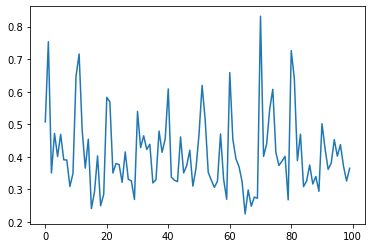

In [13]:
plt.plot(range(len(loss_curve)), loss_curve)

In [ ]:
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [ ]:
for i in range(len(loss_curve)//10):

In [14]:
len(loss_curve)

100